In [14]:
import re, os, glob
from pathlib import Path
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import box
import rioxarray as rxr
from rasterio.enums import Resampling
import xarray as xr



In [15]:
# ------- CONFIG -------
AOI = r"D:\DataMining\Fire-Detection-Data-Mining-Project\ExtractedDatasets\GeoBoundaries\AOI_DZA_TUN\aoi_dza_tun.gpkg"
CLIM_DIR = r"D:\DataMining\Fire-Detection-Data-Mining-Project\Datasets\ClimateDataset"
OUT_DIR  = r"D:\DataMining\Fire-Detection-Data-Mining-Project\ExtractedDatasets\ClimateFeatures"
GRID_GPKG = None  # set to an existing grid path if you already created one, else it will be created below
GRID_RES_DEG = 0.1  # ~11km; you can use 0.0833 (~5') to match WorldClim

Path(OUT_DIR).mkdir(parents=True, exist_ok=True)


In [16]:
# ------- 1A) Build grid over AOI if you don't have one -------
def build_grid_from_aoi(aoi_path, res_deg=0.1, out_gpkg=None):
    aoi = gpd.read_file(aoi_path)
    aoi = aoi.to_crs("EPSG:4326")
    w,s,e,n = aoi.total_bounds
    xs = np.arange(w, e, res_deg)
    ys = np.arange(s, n, res_deg)
    cells = [box(x,y,x+res_deg,y+res_deg) for x in xs for y in ys]
    grid_bbox = gpd.GeoDataFrame(geometry=cells, crs="EPSG:4326")
    grid = gpd.overlay(grid_bbox, aoi[["geometry"]], how="intersection", keep_geom_type=True)
    grid = grid.reset_index(drop=True).reset_index(names="cell_id")
    if out_gpkg:
        grid.to_file(out_gpkg, layer="grid", driver="GPKG")
    return grid

if GRID_GPKG is None:
    GRID_GPKG = os.path.join(OUT_DIR, f"grid_{str(GRID_RES_DEG).replace('.','p')}.gpkg")
    grid = build_grid_from_aoi(AOI, res_deg=GRID_RES_DEG, out_gpkg=GRID_GPKG)
else:
    grid = gpd.read_file(GRID_GPKG, layer="grid") if GRID_GPKG.lower().endswith(".gpkg") else gpd.read_file(GRID_GPKG)

# Precompute centroids for fast sampling
grid = grid.to_crs("EPSG:4326")
centroids = grid.geometry.centroid
centroids_xy = np.column_stack([centroids.x.values, centroids.y.values])



C:\Users\E15\AppData\Local\Temp\ipykernel_11196\239725240.py:24: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = grid.geometry.centroid


Grid CRS: EPSG:4326 | cells: 23322


,cell_id,geometry
0,0,"POLYGON ((-8.56891 27.26815, -8.56891 27.25678..."
1,1,"POLYGON ((-8.56891 27.36815, -8.56891 27.26815..."
2,2,"POLYGON ((-8.56891 27.46815, -8.56891 27.36815..."
3,3,"POLYGON ((-8.56891 27.56815, -8.56891 27.46815..."
4,4,"POLYGON ((-8.56891 27.66815, -8.56891 27.56815..."


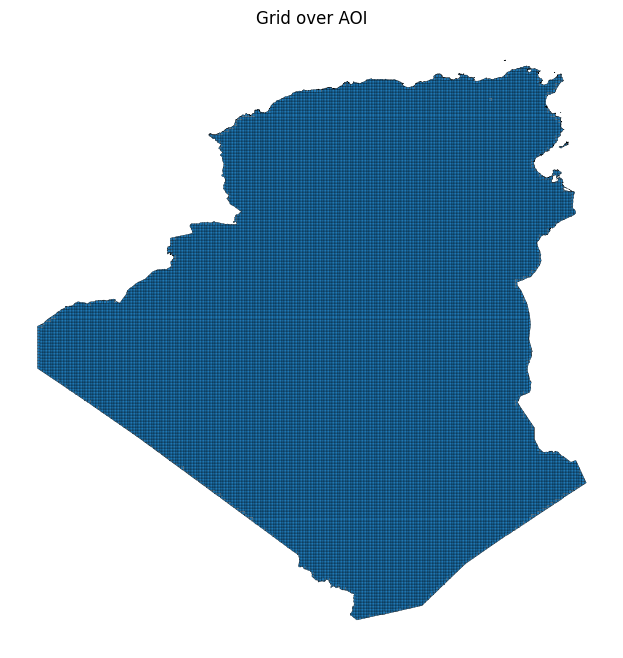

In [17]:
# Display basic info and plot the grid
print(f"Grid CRS: {grid.crs} | cells: {len(grid)}")

ax = grid.plot(figsize=(10, 8), edgecolor="black", linewidth=0.2)
ax.set_title("Grid over AOI")
ax.set_axis_off()

# show a preview of the GeoDataFrame
grid.head()

In [18]:
# ------- 1B) Helper: open, reproject, clip, sample -------
def open_clip_reproj(path_tif, aoi_gdf, dst_crs="EPSG:4326"):
    da = rxr.open_rasterio(path_tif).squeeze()  # shape: (y, x)
    # attach CRS if missing
    if not da.rio.crs:
        da = da.rio.write_crs(dst_crs, inplace=False)
    if da.rio.crs.to_string() != dst_crs:
        da = da.rio.reproject(dst_crs, resampling=Resampling.bilinear)
    da = da.rio.clip(aoi_gdf.geometry, crs=aoi_gdf.crs, drop=True)
    return da

def sample_centroids(da, xy):
    # Handle coord names (x/y or lon/lat)
    coord_x = "x" if "x" in da.coords else ("lon" if "lon" in da.coords else list(da.coords)[1])
    coord_y = "y" if "y" in da.coords else ("lat" if "lat" in da.coords else list(da.coords)[0])
    xs, ys = xy[:,0], xy[:,1]
    # Nearest-neighbor sample at centroids
    vals = da.sel({coord_x: xr.DataArray(xs, dims="points"),
                   coord_y: xr.DataArray(ys, dims="points")},
                  method="nearest").values
    return vals

def parse_year_month_from_filename(path):
    # expects ..._YYYY-MM.tif at the end
    m = re.search(r"(\d{4})-(\d{2})\.tif$", os.path.basename(path))
    if not m:
        raise ValueError(f"Cannot parse YYYY-MM from {path}")
    return int(m.group(1)), int(m.group(2))


In [19]:
def save_table(df, parquet_path, csv_if_needed=True):
    """
    Try Parquet first. If pyarrow/fastparquet is missing, optionally fall back to CSV.
    """
    try:
        df.to_parquet(parquet_path)  # will use pyarrow/fastparquet if available
        print("Saved Parquet →", parquet_path)
        return parquet_path
    except Exception as e:
        print("Parquet failed:", e)
        if csv_if_needed:
            csv_path = os.path.splitext(parquet_path)[0] + ".csv"
            df.to_csv(csv_path, index=False)
            print("Saved CSV fallback →", csv_path)
            return csv_path
        else:
            raise


In [20]:
# ------- 1C) Process one variable dir into a parquet -------
def process_variable(var_dir, var_name, out_parquet, scale=None):
    aoi = gpd.read_file(AOI).to_crs("EPSG:4326")
    files = sorted(glob.glob(os.path.join(var_dir, "*.tif")))
    rows = []
    for f in files:
        y, m = parse_year_month_from_filename(f)
        da = open_clip_reproj(f, aoi, dst_crs="EPSG:4326")
        vals = sample_centroids(da, centroids_xy)
        vals = vals.astype("float64")
        if scale is not None:
            vals = vals * scale
        df = pd.DataFrame({
            "cell_id": grid["cell_id"].values,
            "year": y,
            "month": m,
            var_name: vals
        })
        rows.append(df)
    if not rows:
        raise RuntimeError(f"No files found in {var_dir}")
    out = pd.concat(rows, ignore_index=True)
    save_table(out, out_parquet)   # ← replaces out.to_parquet(out_parquet)
    print(f"Saved {var_name} | rows={len(out)}")
    return out



In [21]:
# set your 3 folders
PREC_DIR = r"D:\DataMining\Fire-Detection-Data-Mining-Project\Datasets\ClimateDataset\wc2.1_cruts4.09_5m_prec_2020-2024"
TMAX_DIR = r"D:\DataMining\Fire-Detection-Data-Mining-Project\Datasets\ClimateDataset\wc2.1_cruts4.09_5m_tmax_2020-2024"
TMIN_DIR = r"D:\DataMining\Fire-Detection-Data-Mining-Project\Datasets\ClimateDataset\wc2.1_cruts4.09_5m_tmin_2020-2024"

prec_df = process_variable(PREC_DIR, "prec_mm", os.path.join(OUT_DIR, "prec_2020_2024.parquet"), scale=None)

# For temperatures, first try with no scaling; if you see values ~300, rerun with scale=0.1
tmax_df = process_variable(TMAX_DIR, "tmax_c", os.path.join(OUT_DIR, "tmax_2020_2024.parquet"), scale=None)
tmin_df = process_variable(TMIN_DIR, "tmin_c", os.path.join(OUT_DIR, "tmin_2020_2024.parquet"), scale=None)


Parquet failed: Unable to find a usable engine; tried using: 'pyarrow', 'fastparquet'.
A suitable version of pyarrow or fastparquet is required for parquet support.
Trying to import the above resulted in these errors:
 - Missing optional dependency 'pyarrow'. pyarrow is required for parquet support. Use pip or conda to install pyarrow.
 - Missing optional dependency 'fastparquet'. fastparquet is required for parquet support. Use pip or conda to install fastparquet.
Saved CSV fallback → D:\DataMining\Fire-Detection-Data-Mining-Project\ExtractedDatasets\ClimateFeatures\prec_2020_2024.csv
Saved prec_mm | rows=1399320
Parquet failed: Unable to find a usable engine; tried using: 'pyarrow', 'fastparquet'.
A suitable version of pyarrow or fastparquet is required for parquet support.
Trying to import the above resulted in these errors:
 - Missing optional dependency 'pyarrow'. pyarrow is required for parquet support. Use pip or conda to install pyarrow.
 - Missing optional dependency 'fastparq

Verifications

In [29]:
# ------- 2) Quick check of clipping/reprojecting logic -------
tmax_path = r"D:\DataMining\Fire-Detection-Data-Mining-Project\Datasets\ClimateDataset\wc2.1_cruts4.09_5m_prec_2020-2024\wc2.1_cruts4.09_5m_prec_2020-01.tif"
aoi_path  = r"D:\DataMining\Fire-Detection-Data-Mining-Project\ExtractedDatasets\GeoBoundaries\AOI_DZA_TUN\aoi_dza_tun.gpkg"

aoi = gpd.read_file(aoi_path).to_crs("EPSG:4326")
da = rxr.open_rasterio(tmax_path).squeeze()

print("Raw raster min/max:", float(da.min()), float(da.max()), "| dtype:", da.dtype)
print("CRS:", da.rio.crs)

# Reproject/clip like in the pipeline
if not da.rio.crs: da = da.rio.write_crs("EPSG:4326", inplace=False)
if da.rio.crs.to_string() != "EPSG:4326":
    from rasterio.enums import Resampling
    da = da.rio.reproject("EPSG:4326", resampling=Resampling.bilinear)

da_clipped = da.rio.clip(aoi.geometry, crs=aoi.crs, drop=True)

print("Clipped min/max:", float(da_clipped.min()), float(da_clipped.max()))
print("NaN ratio:", np.isnan(da_clipped.values).mean())


Raw raster min/max: 0.0 1039.4000244140625 | dtype: float32
CRS: EPSG:4326
Clipped min/max: 0.0 129.9499969482422
NaN ratio: 0.39842375366568916


In [30]:
# assume you still have `grid` and `centroids_xy`
idx = np.random.choice(len(centroids_xy), size=5, replace=False)
xs, ys = centroids_xy[idx,0], centroids_xy[idx,1]

# adapt coordinate names
cx = "x" if "x" in da_clipped.coords else ("lon" if "lon" in da_clipped.coords else list(da_clipped.coords)[1])
cy = "y" if "y" in da_clipped.coords else ("lat" if "lat" in da_clipped.coords else list(da_clipped.coords)[0])

import xarray as xr
vals = da_clipped.sel({cx: xr.DataArray(xs, dims="points"),
                       cy: xr.DataArray(ys, dims="points")},
                      method="nearest").values
print("Sampled values @ 5 random cells:", vals)


Sampled values @ 5 random cells: [3.025 2.9   7.    0.    2.9  ]


In [32]:
df = pd.read_csv(r"D:\DataMining\Fire-Detection-Data-Mining-Project\ExtractedDatasets\ClimateFeatures\prec_2020_2024.csv")  # or pd.read_parquet(...)

print(df.head(20))
print("Unique values in this month (example 2020-01):",
      df.query("year==2020 and month==1")["prec_mm"].nunique())

print(df.describe())


    cell_id  year  month  prec_mm
0         0  2020      1    2.000
1         1  2020      1    2.000
2         2  2020      1    3.000
3         3  2020      1    3.000
4         4  2020      1    3.000
5         5  2020      1    3.000
6         6  2020      1    3.650
7         7  2020      1    3.850
8         8  2020      1    4.800
9         9  2020      1    4.725
10       10  2020      1    5.625
11       11  2020      1    6.050
12       12  2020      1    6.525
13       13  2020      1    6.200
14       14  2020      1    7.000
15       15  2020      1    7.750
16       16  2020      1      NaN
17       17  2020      1    2.000
18       18  2020      1    3.000
19       19  2020      1    3.000
Unique values in this month (example 2020-01): 2340
            cell_id          year         month       prec_mm
count  1.399320e+06  1.399320e+06  1.399320e+06  1.383840e+06
mean   1.166050e+04  2.022000e+03  6.500000e+00  5.592143e+00
std    6.732484e+03  1.414214e+00  3.452054e+00 